In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np 
import pandas as pd 
from scipy import signal
import matplotlib.pyplot as plt

# Import RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_columns', 144)

In [4]:
stock = pd.read_csv('/Users/k0s00ks/Documents/iRage Capital/Data Science Assignment (Latest)/s1.csv')

After decompressing the file, you would get "s1.csv" file.

This file contains data for one particular stock only and has the following header:

date,b0,a0,bsz0,bidx0,sidx0,ssz0,bsz1,bidx1,sidx1,ssz1,bsz2,bidx2,sidx2,ssz2,bsz3,bidx3,sidx3,ssz3,bsz4,bidx4,sidx4,ssz4,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,b0_cm,a0_cm,bsz0_cm,bidx0_cm,sidx0_cm,ssz0_cm,bsz1_cm,bidx1_cm,sidx1_cm,ssz1_cm,bsz2_cm,bidx2_cm,sidx2_cm,ssz2_cm,bsz3_cm,bidx3_cm,sidx3_cm,ssz3_cm,bsz4_cm,bidx4_cm,sidx4_cm,ssz4_cm,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,30secAhead,1minAhead

date refers to particular time of at which the data is captured.
b0/b0_cm and a0/a0_cm refers to top bid and top ask for future and cash segment for the respective stock. 
bidx[0-4] and sidx[0-4] refers to distance from top level for bid/ask
bsz[0-4] and ssz[0-4] refers to size at that level.
There are different features pre-computed ( e.g.. momentum ) which are also given. ( e.g.. f1,f2, ... f148 )

30secAhead and 1minAhead are prices 30 seconds and 1 minutes in future. These columns should not be used for prediction/classification purpose.

In [5]:
cols = list(stock.columns.values)
print (cols)
nrows, ncols = stock.shape
print ('Number of rows and columns are :',nrows, ncols )

['date', 'b0', 'a0', 'bsz0', 'bidx0', 'sidx0', 'ssz0', 'bsz1', 'bidx1', 'sidx1', 'ssz1', 'bsz2', 'bidx2', 'sidx2', 'ssz2', 'bsz3', 'bidx3', 'sidx3', 'ssz3', 'bsz4', 'bidx4', 'sidx4', 'ssz4', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'b0_cm', 'a0_cm', 'bsz0_cm', 'bidx0_cm', 'sidx0_cm', 'ssz0_cm', 'bsz1_cm', 'bidx1_cm', 'sidx1_cm', 'ssz1_cm', 'bsz2_cm', 'bidx2_cm', 'sidx2_cm', 'ssz2_cm', 'bsz3_cm', 'bidx3_cm', 'sidx3_cm', 'ssz3_cm', 'bsz4_cm', 'bidx4_cm', 'sidx4_cm', 'ssz4_cm', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124

In [6]:
stock.head(5)

,date,b0,a0,bsz0,bidx0,sidx0,ssz0,bsz1,bidx1,sidx1,ssz1,bsz2,bidx2,sidx2,ssz2,bsz3,bidx3,sidx3,ssz3,bsz4,bidx4,sidx4,ssz4,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,b0_cm,a0_cm,bsz0_cm,bidx0_cm,sidx0_cm,ssz0_cm,bsz1_cm,bidx1_cm,sidx1_cm,ssz1_cm,bsz2_cm,bidx2_cm,sidx2_cm,ssz2_cm,bsz3_cm,bidx3_cm,sidx3_cm,ssz3_cm,bsz4_cm,bidx4_cm,sidx4_cm,ssz4_cm,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,30secAhead,1minAhead
0,2016-10-27 09:21:01,6320.0,6327.0,1.0,35.0,35.0,2.0,2.0,25.0,15.0,1.0,1.0,60.0,50.0,1.0,1.0,35.0,20.0,2.0,1.0,65.0,70.0,2.0,3600.0,102.0,102.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,273000.0,252000.0,69000.0,75000.0,6315,6316,0.066667,5,5,0.142,0.154667,10,10,0.033333,1.866667,10,10,0.210667,0.405333,15,15,2.472,0.049333,15,15,0.288,762,33,33,0.603333,0.0,0,0,0.0,0.000000,0,0,0.000000,0,0,0,0,0,0,0,0,-7,-1,0,0,0,0,0,0,0,0,134310,153263,30069,23398,6315.624091,6316.609275,420.0,0.602885,1.813623,0.000023,-0.008956,0.741935,0.741935,0.0,0.000791,-0.041667,0.040000,0.124769,-0.065907,0,0,0,0,0.011364,0.225281,0.713782,-0.382476,0.0,0.0,-0.000099,-0.000255,0.000693,0.000537,-9.0,-19.0
1,2016-10-27 09:21:02,6320.0,6326.0,1.0,30.0,30.0,1.0,1.0,25.0,5.0,2.0,1.0,55.0,45.0,1.0,1.0,35.0,20.0,1.0,1.0,60.0,50.0,2.0,3000.0,90.0,90.0,2.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,-55.0,0.0,1.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,2.0,2.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,270000.0,255000.0,69000.0,75000.0,6315,6316,0.066667,5,5,0.142,0.017333,10,10,0.033333,1.866667,10,10,0.094667,0.405333,15,15,2.000,0.049333,15,15,0.288,721,33,33,0.152667,0.0,0,0,0.0,-0.088000,-20,-20,-0.893333,8,3,0,0,0,2,0,0,0,-2,0,0,3,8,0,0,0,0,128104,153089,24363,21715,6315.618479,6316.602517,405.0,0.648711,1.821854,0.073260,-0.004427,0.741935,0.741935,0.0,0.000791,-0.041667,0.028571,0.057468,-0.088854,0,0,0,0,-0.336487,0.298750,0.000000,-0.775236,0.0,0.0,-0.000098,-0.000254,0.000694,0.000538,-9.0,-20.0
2,2016-10-27 09:21:03,6320.0,6326.0,1.0,30.0,30.0,2.0,1.0,20.0,5.0,2.0,1.0,50.0,45.0,1.0,1.0,35.0,20.0,1.0,1.0,55.0,50.0,2.0,3000.0,85.0,85.0,3.0,0.0,0.0,0.0,1.0,0.0,25.0,0.0,1.0,3.0,14.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,2.0,2.0,2.0,14.0,3.0,0.0,0.0,0.0,0.0,267000.0,258000.0,69000.0,81000.0,6315,6316,0.066667,5,5,0.142,0.284000,10,10,0.033333,1.866667,10,10,0.094667,0.405333,15,15,2.000,0.049333,15,15,0.288,801,33,33,-0.114000,0.0,0,0,0.0,0.266667,0,0,0.000000,1,52,0,0,0,7,0,0,6,-3,0,0,52,1,0,0,0,0,134504,153089,30763,18697,6315.612922,6316.595805,405.0,0.648725,1.821895,0.000023,-0.004405,0.741935,0.741935,0.0,0.000791,-0.080000,0.017143,0.243955,-0.064623,0,0,0,0,-0.510802,-0.318424,0.652317,1.445756,0.0,0.0,-0.000097,-0.000253,0.000694,0.000539,-8.0,-26.0
3,2016-10-27 09:21:04,6320.0,6326.0,1.0,30.0,30.0,1.0,1.0,10.0,5.0,1.0,1.0,60.0,45.0,1.0,1.0,20.0,20.0,1.0,1.0,65.0,50.0,2.0,3000.0,81.0,81.0,1.0,0.0,0.0,0.0,-1.0,0.0,20.0,0.0,-2.0,5.0,13.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,2.0,2.0,2.0,13.0,5.0,0.0,0.0,0.0,0.0,270000.0,252000.0,69000.0,72000.0,6315,6316,0.066667,5,5,0.142,0.154667,10,10,0.033333,1.866667,10,10,0.094667,0.405333,15,15,2.000,0.049333,15,15,0.288,762,33,33,0.015333,0.0,0,0,0.0,-0.129333,0,0,0.000000,11,91,0,1,0,13,0,0,13,-4,0,0,91,11,1,0,241,0,135302,154040,30569,18697,6315.607419,6316.589138,405.0,0.648740,1.821936,0.000023,-0.004382,0.741935,0.741935,0.0,0.000791,-0.021277,0.034483,0.240978,-0.064761,0,0,0,0,0.698877,0.002133,-1.324400,-0.012278,0.0,0.0,-0.000096,-0.000252,0.000695,0.000540,-7.0,-25.0
4,2016-10-27 09:21:05,6320.0,6325.0,1.0,25.0,25.0,2.0,1.0,20.0,5.0,1.0,1.0,45.0,30.0,1.0,1.0,30.0,20.0,1.0,1.0,55.0,45.0,1.0,3000.0,75.0,75.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,-45.

In [7]:
stock.tail()

,date,b0,a0,bsz0,bidx0,sidx0,ssz0,bsz1,bidx1,sidx1,ssz1,bsz2,bidx2,sidx2,ssz2,bsz3,bidx3,sidx3,ssz3,bsz4,bidx4,sidx4,ssz4,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,b0_cm,a0_cm,bsz0_cm,bidx0_cm,sidx0_cm,ssz0_cm,bsz1_cm,bidx1_cm,sidx1_cm,ssz1_cm,bsz2_cm,bidx2_cm,sidx2_cm,ssz2_cm,bsz3_cm,bidx3_cm,sidx3_cm,ssz3_cm,bsz4_cm,bidx4_cm,sidx4_cm,ssz4_cm,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,30secAhead,1minAhead
636947,2016-09-06 14:33:28,5922.0,5926.0,2.0,20.0,20.0,1.0,1.0,5.0,10.0,1.0,1.0,25.0,25.0,2.0,1.0,10.0,15.0,1.0,2.0,30.0,30.0,1.0,4200.0,44.0,44.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3126000.0,4683000.0,102000.0,123000.0,5890,5893,0.188667,15,15,0.144667,0.322667,5,5,0.389333,0.051333,20,20,0.033333,0.238000,10,10,1.609333,2.629333,25,25,0.316,1029,35,35,-0.937333,0.000,0,0,0.000000,0.000000,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,500726,837156,52781,23949,5887.580791,5891.596663,40.0,0.363534,0.373271,0.000000,-0.029026,0.364103,0.6,0.0,0.005418,-0.093333,-0.199385,0.375759,-0.251465,0,0,0,0,0.0,0.001130,0.0,-0.062347,0.0,0.00000,0.000411,-0.000271,0.005829,0.005147,0.0,0.0
636948,2016-09-06 14:33:29,5922.0,5926.0,2.0,20.0,20.0,1.0,1.0,5.0,10.0,1.0,1.0,25.0,25.0,2.0,1.0,10.0,15.0,1.0,2.0,30.0,30.0,1.0,4200.0,44.0,44.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3126000.0,4683000.0,102000.0,123000.0,5890,5893,0.188667,15,15,0.144000,0.322667,5,5,0.389333,0.051333,20,20,0.033333,0.238000,10,10,1.609333,2.629333,25,25,0.316,1029,35,35,-0.938000,0.000,0,0,-0.000667,0.000000,0,0,-0.000667,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,500626,837156,52481,23949,5887.600784,5891.594006,40.0,0.363534,0.373271,0.000000,-0.029026,0.364103,0.6,0.0,0.005418,-0.093333,-0.199385,0.373309,-0.251558,0,0,0,0,0.0,0.000370,0.0,-0.006541,0.0,0.00000,0.000407,-0.000271,0.005826,0.005148,0.0,0.0
636949,2016-09-06 14:33:30,5922.0,5926.0,2.0,20.0,20.0,1.0,1.0,5.0,10.0,1.0,1.0,25.0,25.0,2.0,1.0,10.0,15.0,1.0,2.0,30.0,30.0,1.0,4200.0,44.0,44.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3126000.0,4683000.0,102000.0,123000.0,5890,5893,0.188667,15,15,0.143333,0.322667,5,5,0.389333,0.051333,20,20,0.033333,0.238000,10,10,1.609333,2.629333,25,25,0.316,1029,35,35,-0.938667,0.000,0,0,0.000000,0.000000,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,500626,837156,52481,23949,5887.620613,5891.591354,45.0,0.361785,0.373271,-0.004823,-0.029025,0.364103,0.6,0.0,0.005418,-0.093333,-0.199385,0.373309,-0.251558,0,0,0,0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000404,-0.000270,0.005822,0.005148,0.0,0.0
636950,2016-09-06 14:33:31,5922.0,5926.0,2.0,20.0,20.0,1.0,1.0,5.0,10.0,1.0,1.0,25.0,25.0,2.0,1.0,10.0,15.0,1.0,2.0,30.0,30.0,1.0,4200.0,44.0,44.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3126000.0,4683000.0,102000.0,123000.0,5891,5893,0.112667,10,10,0.136667,0.076000,5,5,0.389333,0.322667,15,15,0.033333,0.051333,10,10,1.609333,0.238000,20,20,0.316,240,30,30,1.684000,-0.076,1,0,-0.006667,-2.629333,25,0,-0.006667,0,2,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,10,500625,837156,52480,23949,5887.648541,5891.590370,40.0,0.363534,0.373271,0.004824,-0.029025,0.364103,0.6,0.0,0.005248,-0.093333,-0.199385,0.373301,-0.251559,0,0,0,0,0.0,0.000004,0.0,-0.000021,0.0,0.00017,0.000569,-0.000100,0.005818,0.005148,0.0,0.0
636951,2016-09-06 14:33:32,5922.0,5926.0,2.0,20.0,20.0,1.0,1.0,5.0,10.0,1.0,1.0,25.0,25.0,2.0,1.0,10.0,15.0,1.0,2.0,30.0,30.0,1.0,4200.0,44.0,44.0,-1.0,0.0,0.0,0.0,0.0,0.0,

In [8]:
stock.describe()

,b0,a0,bsz0,bidx0,sidx0,ssz0,bsz1,bidx1,sidx1,ssz1,bsz2,bidx2,sidx2,ssz2,bsz3,bidx3,sidx3,ssz3,bsz4,bidx4,sidx4,ssz4,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,b0_cm,a0_cm,bsz0_cm,bidx0_cm,sidx0_cm,ssz0_cm,bsz1_cm,bidx1_cm,sidx1_cm,ssz1_cm,bsz2_cm,bidx2_cm,sidx2_cm,ssz2_cm,bsz3_cm,bidx3_cm,sidx3_cm,ssz3_cm,bsz4_cm,bidx4_cm,sidx4_cm,ssz4_cm,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,30secAhead,1minAhead
count,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,6.369520e+05,6.369520e+05,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.00000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,6.369520e+05,6.369520e+05,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,6.369520e+05,636952.000000,636952.000000,636952.000000,636952.000000,6.369520e+05,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,6.369520e+05,6.369520e+05,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000
mean,6018.829987,6023.907466,1.453929,25.387392,25.387392,1.476166,1.554364,7.994354,8.057491,1.616459,1.695360,33.504259,33.522455,1.763649,1.773862,16.732729,16.782293,1.864505,1.799603,42.632789,42.489638,1.932954,4966.270928,58.584440,58.584440,0.376616,-0.003036,0.008921,-0.004459,-0.003192,-0.004540,0.280649,-0.133589,-0.003909,2.246050,2.191237,0.049939,0.041568,0.677038,0.666540,9.024228,8.831121,-1.833498,-2.049679,0.070123,0.067551,2.191237,2.246050,0.041568,0.049939,131.732061,159.157990,2.257804e+06,3.006445e+06,111243.856680,137198.821889,6007.781108,6010.176726,0.319223,11.978093,11.978093,0.260244,0.405890,6.662920,6.810121,0.337748,0.559258,17.614891,17.645309,0.484486,0.757948,12.038113,12.214822,0.656732,0.956588,22.961911,23.085586,0.832749,899.271694,36.008351,36.008351,-0.426948,-0.000220,0.001637,0.007944,0.000625,0.001707,0.046149,0.16327,0.002838,6.237625,5.979895,0.493901,0.412783,0.567724,0.601579,1.193883,2.102673,-7.779666,-8.004014,0.154159,-0.000104,5.979895,6.237625,0.412783,0.493901,40.225654,43.393541,6.172423e+05,6.774426e+05,36321.498078,35141.673931,6007.571278,6006.970744,73.673299,0.377404,2.386418e+02,0.000007,0.012183,0.424381,0.481663,7.881175e-07,0.001918,-0.088929,-0.152032,0.019183,-0.

In [9]:
labels = []
values = []
for col in stock.columns:
    labels.append(col)
    values.append(stock[col].isnull().sum())
    print(col, values[-1])

date 0
b0 0
a0 0
bsz0 0
bidx0 0
sidx0 0
ssz0 0
bsz1 0
bidx1 0
sidx1 0
ssz1 0
bsz2 0
bidx2 0
sidx2 0
ssz2 0
bsz3 0
bidx3 0
sidx3 0
ssz3 0
bsz4 0
bidx4 0
sidx4 0
ssz4 0
f25 0
f26 0
f27 0
f28 0
f29 0
f30 0
f31 0
f32 0
f33 0
f34 0
f35 0
f36 0
f37 0
f38 0
f39 0
f40 0
f41 0
f42 0
f43 0
f44 0
f45 0
f46 0
f47 0
f48 0
f49 0
f50 0
f51 0
f52 0
f53 0
f54 0
f55 0
f56 0
f57 0
f58 0
b0_cm 0
a0_cm 0
bsz0_cm 0
bidx0_cm 0
sidx0_cm 0
ssz0_cm 0
bsz1_cm 0
bidx1_cm 0
sidx1_cm 0
ssz1_cm 0
bsz2_cm 0
bidx2_cm 0
sidx2_cm 0
ssz2_cm 0
bsz3_cm 0
bidx3_cm 0
sidx3_cm 0
ssz3_cm 0
bsz4_cm 0
bidx4_cm 0
sidx4_cm 0
ssz4_cm 0
f82 0
f83 0
f84 0
f85 0
f86 0
f87 0
f88 0
f89 0
f90 0
f91 0
f92 0
f93 0
f94 0
f95 0
f96 0
f97 0
f98 0
f99 0
f100 0
f101 0
f102 0
f103 0
f104 0
f105 0
f106 0
f107 0
f108 0
f109 0
f110 0
f111 0
f112 0
f113 0
f114 0
f115 0
f116 0
f117 0
f118 0
f119 0
f120 0
f121 0
f122 0
f123 0
f124 0
f125 0
f126 0
f127 0
f128 0
f129 0
f130 0
f131 0
f132 0
f133 0
f134 0
f139 0
f140 0
f141 0
f142 0
f143 0
f144 0
f145 0
f

In [10]:
stock['date'] = pd.to_datetime(stock['date'])
stock['Time'],stock['Date']= stock['date'].apply(lambda x:x.time()), stock['date'].apply(lambda x:x.date())

In [11]:
stock_list = ['b0', 'a0', 'bsz0', 'bidx0', 'sidx0', 'ssz0', 'bsz1', 'bidx1', 'sidx1', 
               'ssz1', 'bsz2', 'bidx2', 'sidx2', 'ssz2', 'bsz3', 'bidx3', 'sidx3', 'ssz3', 
               'bsz4', 'bidx4', 'sidx4', 'ssz4', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 
               'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 
               'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 
               'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'b0_cm', 'a0_cm', 'bsz0_cm', 'bidx0_cm', 
               'sidx0_cm', 'ssz0_cm', 'bsz1_cm', 'bidx1_cm', 'sidx1_cm', 'ssz1_cm', 'bsz2_cm', 'bidx2_cm', 
               'sidx2_cm', 'ssz2_cm', 'bsz3_cm', 'bidx3_cm', 'sidx3_cm', 'ssz3_cm', 'bsz4_cm', 'bidx4_cm',
               'sidx4_cm', 'ssz4_cm', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91',
               'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 
               'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 
               'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 
               'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 
               'f145', 'f146', 'f147', 'f148', '30secAhead', '1minAhead']

corrmat_pearson = stock[stock_list].corr(method='pearson')
corrmat_spearman = stock[stock_list].corr(method='spearman')

# Checking correlations
Let's look at variables having the largest correlation with the '30secAhead' and '1minuteAhead'

In [59]:
# Top list of correlations using pearson correlation
print (corrmat_pearson['30secAhead'].loc[corrmat_pearson['30secAhead'] > 0.08]) 

# Top list of correlations using spearman correlation
print (corrmat_pearson['30secAhead'].loc[corrmat_spearman['30secAhead'] > 0.08])

bidx0         0.143704
sidx0         0.143704
bidx2         0.113318
sidx2         0.126984
bidx4         0.098598
sidx4         0.114125
f26           0.082183
f27           0.082183
30secAhead    1.000000
1minAhead     0.700067
Name: 30secAhead, dtype: float64

In [48]:
# Checking for variables having high negative correlations with the predictor variable

# Top list of correlations using pearson correlation
print (corrmat_pearson['30secAhead'].loc[corrmat_pearson['30secAhead'] < -0.05]) 

# Top list of correlations using spearman correlation
print (corrmat_pearson['30secAhead'].loc[corrmat_spearman['30secAhead'] < -0.05])

['bidx1', 'bidx3', 'bsz3_cm', 'bsz4_cm', 'f82', 'f114', '1minAhead']


In [49]:
# We will check for correlations between these extracted variables to check for correlation clustering occuring between them

extracted = list(corrmat['1minAhead'].loc[corrmat['1minAhead'] < -0.05].index)
extracted.append('1minAhead')
corrmat_new = stock[extracted].corr(method='spearman')

corrmat_new

,bidx1,bidx3,bsz3_cm,bsz4_cm,f82,f114,1minAhead
bidx1,1.000000,0.640734,0.043837,0.046432,0.045521,0.032522,-0.083306
bidx3,0.640734,1.000000,0.015576,0.023330,0.011446,0.010632,-0.063123
bsz3_cm,0.043837,0.015576,1.000000,0.231469,0.591744,0.323936,-0.055540
bsz4_cm,0.046432,0.023330,0.231469,1.000000,0.638579,0.343586,-0.050710
f82,0.045521,0.011446,0.591744,0.638579,1.000000,0.524777,-0.059470
f114,0.032522,0.010632,0.323936,0.343586,0.524777,1.000000,-0.050462
1minAhead,-0.083306,-0.063123,-0.055540,-0.050710,-0.059470,-0.050462,1.000000


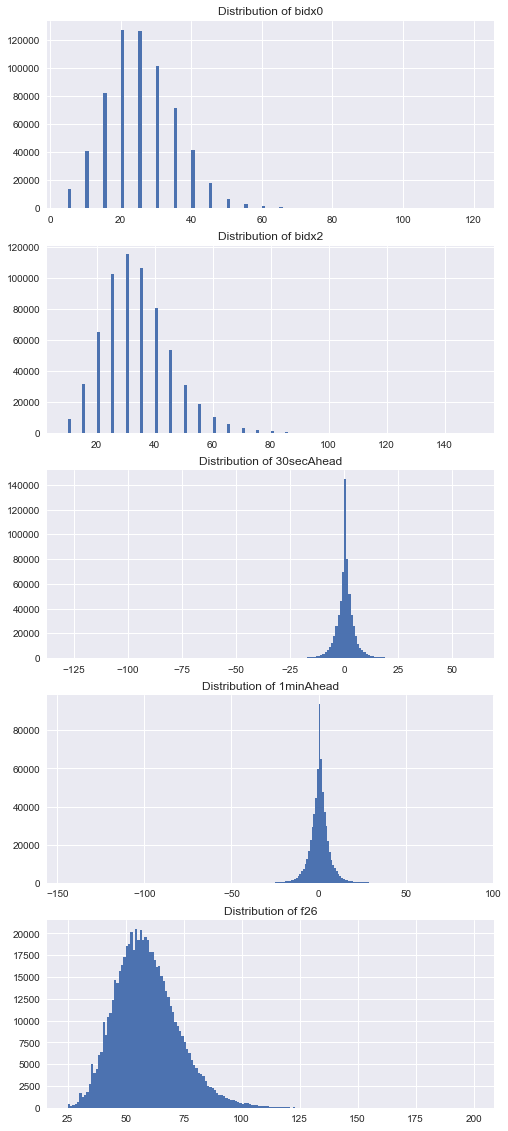

In [55]:
cols_to_use = ['bidx0', 'bidx2', '30secAhead', '1minAhead','f26']
fig = plt.figure(figsize=(8, 20))
plot_count = 0
for col in cols_to_use:
    plot_count += 1
    plt.subplot(5, 1, plot_count)
    plt.hist(stock[col], bins = np.arange(stock[col].min(), stock[col].max()+1))
    plt.title("Distribution of "+ col)
plt.show()

Lets see data by the time of the day across days

In [108]:
m, n = stock.shape
col = stock.columns
plt.figure(figsize=(8, 50))
k = 0
for i in range(2, n-2):
    k += 1
    col_ = stock[col[i]][stock[col[i]].notnull()]
    q_high = col_.quantile(0.75)
    q_low = col_.quantile(0.25)
    iqr = (q_high - q_low) * 1.5
    high = q_high + iqr
    low = q_low -iqr
    col_ = col_[(col_ < high) & (col_ > low)]
    plt.subplot(40, 4, k)
    plt.hist(col_, bins=100)
    plt.xticks()
    plt.title(str(i) + ' ' + col[i])
    plt.tight_layout(pad=0)

# Model buiding and data test/train subsetting

Now we start to build models to predict the 30 second change. 
MODEL 1: Random Forest Regressor

Firstly we divide the data into test and train sets. The test set consists of the last 15 days data.

In [67]:
cols = stock.columns
cols.drop('30secAhead', '1minAhead')
stock['Date'] = pd.to_datetime(stock['Date'])
y_cols = ['30secAhead', '1minAhead', 'Date', 'Time', 'date']
X, y = stock[cols], stock[y_cols]
X_train, X_test = X.loc[X['Date'] < pd.to_datetime('2016-10-15', format = '%Y-%m-%d' )], X.loc[X['Date'] >= pd.to_datetime('2016-10-15', format = '%Y-%m-%d' )]
y_train, y_test = y.loc[y['Date'] < pd.to_datetime('2016-10-15', format = '%Y-%m-%d' )], y.loc[y['Date'] >= pd.to_datetime('2016-10-15', format = '%Y-%m-%d' )]

For the training model we are keeping in cosideration all the columns except the date column. The predictor variable will be the 30secAhead.

In [72]:
model_cols_X = ['b0', 'a0', 'bsz0', 'bidx0', 'sidx0', 'ssz0', 'bsz1', 'bidx1', 
                'sidx1', 'ssz1', 'bsz2', 'bidx2', 'sidx2', 'ssz2', 'bsz3', 'bidx3', 
                'sidx3', 'ssz3', 'bsz4', 'bidx4', 'sidx4', 'ssz4', 'f25', 'f26', 
                'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 
                'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 
                'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 
                'f57', 'f58', 'b0_cm', 'a0_cm', 'bsz0_cm', 'bidx0_cm', 'sidx0_cm', 'ssz0_cm',
                'bsz1_cm', 'bidx1_cm', 'sidx1_cm', 'ssz1_cm', 'bsz2_cm', 'bidx2_cm', 'sidx2_cm',
                'ssz2_cm', 'bsz3_cm', 'bidx3_cm', 'sidx3_cm', 'ssz3_cm', 'bsz4_cm', 'bidx4_cm', 
                'sidx4_cm', 'ssz4_cm', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 
                'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 
                'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 
                'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 
                'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 
                'f131', 'f132', 'f133', 'f134', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 
                'f145', 'f146', 'f147', 'f148']

model_cols_y = ['30secAhead', '1minAhead']

from sklearn.ensemble import RandomForestRegressor

rf0 = RandomForestRegressor(n_jobs=-1, verbose=1)
rf0.fit(X_train[model_cols_X], y_train['30secAhead'])

[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed: 10.2min remaining: 71.6min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 10.5min finished


RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           min_density=None, min_samples_leaf=1, min_samples_split=2,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=1)

We will make a matrix containing the importance rating form this model. This will help us eliminate the variables which are not important in predicting the target.

In [84]:
imporatnce_matrix = pd.DataFrame(0, index = X_train[model_cols_X].columns, columns = ['Importance'])
imporatnce_matrix['Importance'] = rf0.feature_importances_
imporatnce_matrix.sort('Importance', ascending=False).head(20).index

/Users/k0s00ks/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


Index([u'bidx0', u'sidx0', u'bidx3', u'f25', u'bidx1', u'f129', u'bsz0',
       u'f85', u'f145', u'f146', u'f128', u'f148', u'f55', u'f121', u'f56',
       u'f114', u'f113', u'f130', u'f112', u'f147'],
      dtype='object')

We see that though score on train data is coming out to be awesome, the result on data fails horribly. The RandomForest model is currently overfitting. We may try the model with less variables.

In [158]:
train_accuracy_rf0 = rf0.score(X_train[model_cols_X], y_train['30secAhead'])
test_accuracy_rf0 = rf0.score(X_test[model_cols_X], y_test['30secAhead'])

print ('Test accuracy is : ' + str(test_accuracy_rf0) + ' and train accuracy is : ' + str(train_accuracy_rf0))

[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    1.9s remaining:   13.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.8s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s remaining:    3.9s


Test accuracy is : -0.639517682379 and train accuracy is : 0.937023825239


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished


# RF Model 2
Using the importance matrix we select the top 20 most important variables for building the ensemble of trees.

In [85]:
rf1 = RandomForestRegressor(n_jobs=-1, verbose=1)
rf1.fit(X_train[imporatnce_matrix.sort('Importance', ascending=False).head(20).index], y_train['30secAhead'])

/Users/k0s00ks/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:  1.3min remaining:  9.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.3min finished


RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           min_density=None, min_samples_leaf=1, min_samples_split=2,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=1)

Here also we see that the model is performing horribly in predicting the 30secAhead changes. A value of less than shows the model is performing worse than random predictions.

In [87]:
train_accuracy_rf1 = rf1.score(X_train[imporatnce_matrix.sort('Importance', ascending=False).head(20).index], y_train['30secAhead'])
test_accuracy_rf1 = rf1.score(X_test[imporatnce_matrix.sort('Importance', ascending=False).head(20).index], y_test['30secAhead'])

print ('Test accuracy is : ' + str(test_accuracy_rf1) + ' and train accuracy is : ' + str(train_accuracy_rf1))

/Users/k0s00ks/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s remaining:    4.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s finished


0.94745863453161339

# RF Model 3 : Classification
This time we try to use even less variables. In addition to this instead of keeping the amount of movement as the predictor we will try to predict the direction of movement. 

We convert the predictor variable to the direction and build a RandomForestClassifier on the top of this taking just the 4 most important variable we got from the importance matrix.

In [248]:
# New binary predictor variables
def create_buckets(data):
    buckets = np.zeros(data.shape[0])
    buckets[data > 0] = 1
    buckets[data == 0] = 0
    buckets[data < 0] = -1
    
    return (buckets)

#30secAhead

y_train_binary = create_buckets (y_train['1minAhead'])
y_test_binary = create_buckets (y_test['1minAhead']) 

def RF_model(model, no_of_features, verbose = True):
    if (no_of_features > len(X_test.columns)):
        no_of_features = len(X_test.columns)
    
    model.fit(X_train[imporatnce_matrix.sort('Importance', ascending=False).head(no_of_features).index], y_train_binary)

    test_accuracy = model.score(X_test[imporatnce_matrix.sort('Importance', ascending=False).head(no_of_features).index], y_test_binary)
    train_accuracy = model.score(X_train[imporatnce_matrix.sort('Importance', ascending=False).head(no_of_features).index], y_train_binary)
    
    if(verbose == True):
        print ('Test accuracy is : ' + str(test_accuracy) + ' and train accuracy is : ' + str(train_accuracy))
    
    return (test_accuracy, train_accuracy)

no_of_features = 4
rf2 = RandomForestClassifier(n_jobs=-1, verbose=1)
RF_model(rf2, no_of_features)

/Users/k0s00ks/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    1.9s remaining:   13.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished
/Users/k0s00ks/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
/Users/k0s00ks/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


Test accuracy is : 0.487318046552 and train accuracy is : 0.497754316631


(0.4873180465524003, 0.4977543166305689)

We see over here that the results are better than random prediction of movement on test dataset. The results on test and train dataset are not hugely different as we saw in the previous results. The model looks good for now. But can be validated more rigrously if we need to take it for trading.

In [254]:
# We would like to check the accuracy of predictions at various levels of probability
def pred_matrix(y_test, model):
    prediction = model.predict_proba(X_test[imporatnce_matrix.sort('Importance', ascending=False).head(no_of_features).index])
    prediction_matrix = pd.DataFrame(0, index = y_test.index, columns = ['date', 'Date','30secAhead', 'Original_direction','+ve_dir_proba','-ve_dir_proba'])
    prediction_matrix['date'] = y_test['date']
    prediction_matrix['Date'] = y_test['Date']
    prediction_matrix['30secAhead'] = y_test_binary
    prediction_matrix['Original_direction'] = y_test_binary
    prediction_matrix['-ve_dir_proba'] = prediction[:,0]
    prediction_matrix['0_dir_proba'] = prediction[:,1]
    prediction_matrix['+ve_dir_proba'] = prediction[:,2]

    return (prediction_matrix)

def accu_above_level(df ,po_lvl , ne_lvl):
    total = df.shape[0]
    prediction = np.zeros(total)
    prediction[df['+ve_dir_proba'].values > po_lvl] = 1
    prediction[df['-ve_dir_proba'].values > ne_lvl] = -1
    number_of_predictions = np.sum(prediction * prediction)
    cnf_matrix = confusion_matrix(prediction_matrix['Original_direction'], prediction)
    pos_prior, neg_prior = np.sum(cnf_matrix[2,:])/ np.sum(cnf_matrix) , np.sum(cnf_matrix[0,:])/ np.sum(cnf_matrix)
    pos_post, neg_post = cnf_matrix[2,2]/ np.sum(cnf_matrix[:,2]) , cnf_matrix[0,0]/ np.sum(cnf_matrix[:,0])
    print ('Posteriors for +ve, -ve are : %2f and %2f; where as priors were %2f and %2f with %d trades available in test period.' %(pos_post, neg_post, pos_prior, neg_prior, number_of_predictions))
    print ('Number of positive trades: %d and negative trades: %d' %(np.count_nonzero(prediction == 1), np.count_nonzero(prediction == -1)))
    return (cnf_matrix)

# Prepare the prediction matrix
prediction_matrix = pred_matrix(y_test, rf2)
# Check the accuracy above a particular level
accu_above_level(prediction_matrix,0.7, 0.6)

/Users/k0s00ks/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.1s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


Posteriors for +ve, -ve are : 0.599519 and 0.558410; where as priors were 0.446637 and 0.425563 with 10332 trades available in test period.
Number of positive trades: 2080 and negative trades: 8252


array([[ 4608, 68521,   662],
       [  816, 21173,   171],
       [ 2828, 73370,  1247]])